In [37]:
import pyclesperanto as cle
import numpy as np
import pandas as pd
import time
import tifffile as tiff
import matplotlib.pyplot as plt
from skimage.io import imread

cle.select_device(1, device_type='gpu')

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.247.01
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

# Image Processing using clEsperanto

We know how to push and pull data towards our device, we can know apply processing function to it.

The clEsperanto API follow a pattern:

> output = cle.operation_name(input, output, args)

Each functions are documented, you can access though your IDE or using the `cle.operation_name?` idiom un notebook

### CPU - Skimage pipeline

Processing time: 0.016704559326171875 seconds


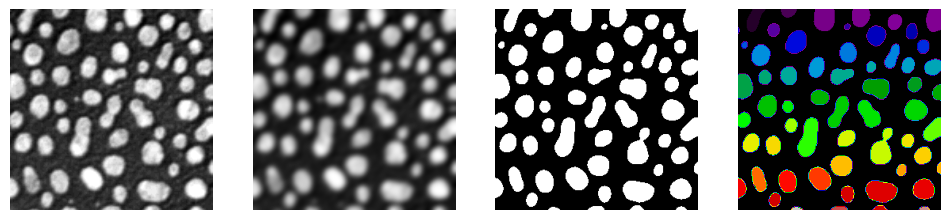

,label,area,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,eccentricity,solidity,orientation,major_axis_length,minor_axis_length,min_intensity,max_intensity,mean_intensity,std_intensity
0,1,421.0,12.881235,20.147268,0,11,29,35,0.875730,0.921225,-0.434905,34.186917,16.505461,104.0,232.0,192.285036,29.571677
1,2,173.0,4.144509,63.132948,0,54,11,74,0.822739,0.966480,-1.513044,20.213669,11.489826,136.0,224.0,182.473988,18.753825
2,3,661.0,12.529501,108.473525,0,95,28,122,0.357974,0.976366,-0.149729,30.338524,28.328037,120.0,248.0,205.155825,30.042153
3,4,444.0,9.887387,154.259009,0,144,23,167,0.381000,0.971554,-0.633719,25.017761,23.130792,96.0,248.0,214.846847,39.182226
4,5,481.0,13.480249,246.767152,0,237,29,256,0.766926,0.975659,-0.025610,31.185763,20.013006,104.0,248.0,211.276507,31.213443


In [44]:
from skimage.filters import gaussian, threshold_otsu
from skimage.measure import label, regionprops_table

image = imread('https://samples.fiji.sc/blobs.png').squeeze()
start = time.time()
blurred_image = gaussian(image, sigma=3)
binary_image = blurred_image > threshold_otsu(blurred_image)
labeled_image = label(binary_image)
props = regionprops_table(labeled_image, intensity_image=image, properties=
                          ['label', 'area', 'centroid', 'bbox', 'eccentricity', 'solidity', 'orientation', 'major_axis_length', 'minor_axis_length', 
                           'min_intensity', 'max_intensity', 'mean_intensity', 'std_intensity'])
print(f"Processing time: {time.time() - start} seconds")

fig, axs = plt.subplots(1, 4, figsize=(12, 6))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(blurred_image, cmap='gray')
axs[2].imshow(binary_image, cmap='gray')
axs[3].imshow(labeled_image, cmap='nipy_spectral')
for ax in axs:
    ax.axis('off')
plt.show()

pd.DataFrame(props).head()

### CPU - clesperanto pipeline

Processing time: 0.01808905601501465 seconds


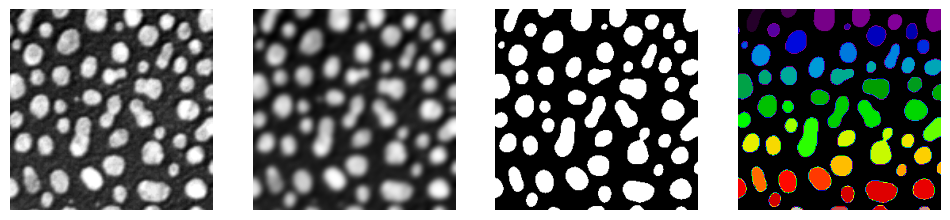

,max_distance_to_mass_center,mean_distance_to_centroid,mean_distance_to_mass_center,sum_distance_to_centroid,centroid_y,max_distance_to_centroid,sum_y,centroid_x,mass_center_z,mass_center_y,...,sum_distance_to_mass_center,bbox_depth,bbox_max_y,centroid_z,bbox_max_z,bbox_max_x,bbox_min_z,bbox_min_y,bbox_min_x,label
0,18.989819,8.673912,8.672676,3651.716797,12.881236,18.916245,5423.0,20.147270,0.0,12.918570,...,3651.196533,1.0,28.0,0.0,0.0,34.0,0.0,0.0,11.0,1.0
1,10.554322,5.353654,5.357302,926.182129,4.144508,10.702135,717.0,63.132946,0.0,4.084643,...,926.813293,1.0,10.0,0.0,0.0,73.0,0.0,0.0,54.0,2.0
2,16.960754,9.759805,9.760290,6460.990723,12.531722,17.041229,8296.0,108.453171,0.0,12.461044,...,6461.312012,1.0,27.0,0.0,0.0,121.0,0.0,0.0,95.0,3.0
3,13.708274,8.011743,8.014387,3565.225586,9.898876,13.904107,4405.0,154.235962,0.0,9.688731,...,3566.402344,1.0,22.0,0.0,0.0,166.0,0.0,0.0,144.0,4.0
4,15.260367,8.624294,8.637898,4148.285645,13.480249,15.795471,6484.0,246.767151,0.0,13.061402,...,4154.829102,1.0,28.0,0.0,0.0,255.0,0.0,0.0,237.0,5.0


In [42]:
image = imread('https://samples.fiji.sc/blobs.png').squeeze()
img = cle.push(image)
start = time.time()
blurred_image = cle.gaussian_blur(img, sigma_x=3, sigma_y=3)
binary_image = cle.threshold_otsu(blurred_image)
labeled_image = cle.connected_component_labeling(binary_image)
props = cle.statistics_of_labelled_pixels(label=labeled_image, intensity=image)
print(f"Processing time: {time.time() - start} seconds")

fig, axs = plt.subplots(1, 4, figsize=(12, 6))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(blurred_image, cmap='gray')
axs[2].imshow(binary_image, cmap='gray')
axs[3].imshow(labeled_image, cmap='nipy_spectral')
for ax in axs:
    ax.axis('off')
plt.show()

pd.DataFrame(props).head()

[Documentation](https://clesperanto-doc.readthedocs.io)